<a href="https://colab.research.google.com/github/donw385/DS-Unit-4-Sprint-2-NLP/blob/master/module2-Bag-of-Words/LS_DS_422_BOW_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import re
import string

!pip install -U nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize # Sentence Tokenizer
from nltk.tokenize import word_tokenize # Word Tokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time

Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.4.1)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1) (optional) Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

In [0]:
max_jobs = 100
title = '"Data Scientist"'
location = 'United States'

def make_urls(job_title, location, max_jobs):
    base_url = 'https://www.indeed.com/jobs?'
    num_pages = max_jobs // 10
    job_title = job_title.replace(' ', '+')
    location = location.replace(' ', '+')
    urls = []
    for p in range(num_pages):
        url = base_url + 'q=' + job_title + '&l=' + location + '&start=' + str(p * 10)
        urls.append(url)
    return urls

In [0]:
def get_listings(job_title, location, max_jobs):
    listings = []
    urls = make_urls(job_title, location, max_jobs)
    
    for url in urls:
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'html.parser')
        listings.extend([s.text for s in soup.findAll(class_='summary')])
        time.sleep(1)
    return list(set(listings)) # return a set because indeed.com duplicates listings

jobs = get_listings(title, location, max_jobs)

In [8]:
jobs[0]


'\n            Translate data analytics into business speak. Data Scientist*with 0.6-1 yrs experience to work for our own clients in different locations in US....'

## 2) Use NLTK to tokenize / clean the listings 

In [0]:

stop_words = stopwords.words('english')

def tokenize_jobs(jobs):
    # remove punctuation
    table = str.maketrans('', '', string.punctuation)
    jobs = [j.translate(table) for j in jobs]
    # tokenize words
    return [word_tokenize(j) for j in jobs]

tokens = tokenize_jobs(jobs)

# 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [10]:
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

# lemmatize
lemmatizer = WordNetLemmatizer()
lemmatized_jobs = []
for listing in tokens:
    lemmas = [lemmatizer.lemmatize(word) for word in listing]
    lemmatized_jobs.append(lemmas)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:

# count vectorizer
vectorizer = CountVectorizer(lowercase=True, stop_words='english')
counts = []
for j in lemmatized_jobs:
    vectorizer.fit(j)
    counts.append(vectorizer.vocabulary_)
counts

[{'061': 0,
  'analytics': 1,
  'business': 2,
  'client': 3,
  'data': 4,
  'different': 5,
  'experience': 6,
  'location': 7,
  'scientistwith': 8,
  'speak': 9,
  'translate': 10,
  'work': 11,
  'yr': 12},
 {'add': 0,
  'analytics': 1,
  'company': 2,
  'currently': 3,
  'data': 4,
  'expertise': 5,
  'growing': 6,
  'manipulating': 7,
  'member': 8,
  'preparation': 9,
  'querying': 10,
  'rpython': 11,
  'scientist': 12,
  'seeking': 13,
  'spark': 14,
  'sql': 15,
  'talented': 16,
  'team': 17,
  'using': 18,
  'visualization': 19},
 {'analysis': 0,
  'analytics': 1,
  'contribute': 2,
  'data': 3,
  'decdg': 4,
  'development': 5,
  'discovery': 6,
  'dissemination': 7,
  'diverse': 8,
  'join': 9,
  'new': 10,
  'operationallyrelevant': 11,
  'perform': 12,
  'product': 13,
  'scientist': 14,
  'tools': 15,
  'unit': 16,
  'visualization': 17},
 {'analysis': 0,
  'data': 1,
  'experience': 2,
  'help': 3,
  'junior': 4,
  'looking': 5,
  'role': 6,
  'science': 7,
  'scienti

# 4) Visualize the most common word counts

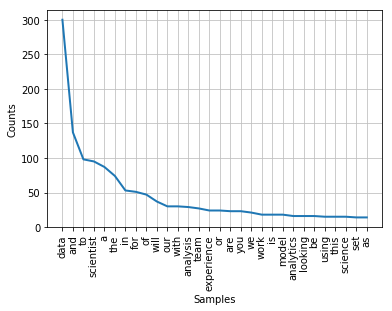

In [12]:
all_jobs = []
for j in lemmatized_jobs:
    for w in j:
        all_jobs.append(w.lower())
fdist = FreqDist(all_jobs)

fdist.plot(30, cumulative=False)
plt.show()

 # 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [13]:
tfidf = TfidfVectorizer(max_features=50, ngram_range=(1,2))

jobs_input = []
for l in lemmatized_jobs:
    s = ''
    for w in l:
        if w not in stopwords.words('english'):
            s += ' ' + w
    jobs_input.append(s)

feature_matrix = tfidf.fit_transform(jobs_input)
# Get feature names to use as dataframe column headers
feature_names = tfidf.get_feature_names()

# View Feature Matrix as DataFrame
df = pd.DataFrame(feature_matrix.toarray(), columns=feature_names)
df.head()

,algorithm,analysis,analytics,as,as data,big,big data,business,company,data,...,source,team,the,this,using,we,we looking,work,working,year
0,0.0,0.000000,0.410516,0.0,0.0,0.0,0.0,0.462266,0.000000,0.283525,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.394249,0.0,0.000000
1,0.0,0.000000,0.387399,0.0,0.0,0.0,0.0,0.000000,0.462388,0.401339,...,0.0,0.329232,0.000000,0.0,0.387399,0.379497,0.000000,0.000000,0.0,0.000000
2,0.0,0.241598,0.284282,0.0,0.0,0.0,0.0,0.000000,0.000000,0.589023,...,0.0,0.000000,0.273017,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,0.0,0.163945,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.333086,...,0.0,0.000000,0.185266,0.0,0.000000,0.188975,0.230252,0.000000,0.0,0.230252
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.131157,...,0.0,0.000000,0.000000,0.0,0.000000,0.372058,0.453324,0.000000,0.0,0.000000


## Stretch Goals

 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.